In [3]:
import jijmodeling as jm

In [5]:
problem_simple = jm.Problem("simple")

a = jm.Placeholder("a")
b = jm.Placeholder("b")
x = jm.Binary("x")

problem_simple += 2 * (a * x + b)
problem_simple.objective

2*a*x+b

In [43]:
problem_sum = jm.Problem("sum")

a = jm.Placeholder("a", 1)
n = jm.Placeholder("n")
i = jm.Element("i", n)
x = jm.Binary("x", n)

problem_sum += jm.Sum(i, a[i] * x[i])
problem_sum.objective

Sum_{i=0}^{n}(a[i]*x[i])

In [57]:
problem_log = jm.Problem("log")

a = jm.Placeholder("a")
problem_log += jm.log2(a)

In [7]:
import sys

sys.path.append("../")

import jijbench as jb

problem_tsp = jb.get_problem("TSP")
problem_tsp

In [150]:
from __future__ import annotations

import jijmodeling as jm
import networkx as nx
import numpy as np
import matplotlib

from typing import Tuple, Optional


class Graph:
    space=1

    def __init__(self, expression: jm.Expression):
        self.expression = expression
        self._data = nx.DiGraph()

    def make(self, node: Optional[Node] = None):
        if node is None:
            node = Node(self.expression)

        if isinstance(node.expression, jm.Number):
            # self._data.add_node(node)
            pass
        elif isinstance(node.expression, jm.Variable):
            # self._data.add_node(node)
            pass
        elif isinstance(node.expression, jm.Subscripts):
            x_org, y_org = node.pos
            n_nodes = len(node.expression.subscripts) + 1
            delta = np.random.uniform(0, self.space / 2)
            wspace = self.space - delta
            x = np.linspace(-wspace / n_nodes, wspace / n_nodes, n_nodes)
            y = self.space - delta
            var_pos = (x_org + x[0], y_org + y)
            subs_pos = [(x_org + xi, y_org + y) for xi in x[1:]]
            var = Node(node.expression.variable, var_pos)
            subs = [Node(sub, pos)  for sub, pos in zip(node.expression.subscripts, subs_pos)]
            edges = [(var, node)] + [(sub, node) for sub in subs]
            self._data.add_edges_from(edges)

            self.make(var)
            for sub in subs:
                self.make(sub)
        elif isinstance(node.expression, jm.UnaryOperator):
            pos = (node.pos[0], node.pos[1] + self.space)
            operand = Node(node.expression.operand, pos)
            self._data.add_edge(operand, node)
            self.make(operand)
        elif isinstance(node.expression, jm.BinaryOperator):
            x_org, y_org = node.pos
            x = np.linspace(-self.space / 2, self.space / 2,  2)
            y = self.space / 2
            lpos = (x_org + x[0], y_org + y)
            rpos = (x_org + x[1], y_org + y)
            left = Node(node.expression.left, lpos)
            right = Node(node.expression.right, rpos)
            edges = [(left, node), (right, node)]
            self._data.add_edges_from(edges)
            
            self.make(left)
            self.make(right)
        elif isinstance(node.expression, jm.expression.sum.ReductionOperator):
            pos = (node.pos[0], node.pos[1] + self.space)
            operand = Node(node.expression.operand, pos)
            self._data.add_edge(operand, node)
            self.make(operand)
        elif isinstance(node.expression, jm.expression.condition.ConditionOperator):
            pass

        return self._data

    def draw(self, **kwargs):
        matplotlib.rcParams["font.family"] = "Times New Roman"
        matplotlib.rcParams['mathtext.fontset'] = 'stix'
        pos = {node: node.pos for node in self._data.nodes}
        nx.draw(self._data, pos=pos, with_labels=True, **kwargs)


class Node:
    def __init__(self, expression: jm.Expression, pos: Optional[Tuple[float, float]]=None):
        self.expression = expression
        if pos is None:
            self.pos = (0.0, 0.0)
        else:
            self.pos = pos
            
        self._depth = 0

    def __repr__(self) -> str:
        if isinstance(self.expression, jm.Number):
            return f"${self.expression}$"
        elif isinstance(self.expression, jm.Variable):
            return f"${self.expression}$"
        elif isinstance(self.expression, jm.Subscripts):
            return f"${self.expression}$"
        elif isinstance(self.expression, jm.UnaryOperator):
            return  self.expression.__class__.__name__
        elif isinstance(self.expression, jm.BinaryOperator):
            if isinstance(self.expression, jm.expression.expression.Mod):
                return "$\mathrm{mod}$"
            else:
                return f"${self.expression._mark}$"
        elif isinstance(self.expression, jm.expression.sum.ReductionOperator):
            sum_index = ""
            if isinstance(self.expression.sum_index.parent, jm.expression.variables.variable.Range):
                sum_index += "{" + "{}={}".format(
                    self.expression.sum_index, self.expression.sum_index.parent.start
                )
                if not isinstance(self.expression.condition, jm.expression.condition.NoneCondition):
                    sum_index += f"({self.expression.condition})"
                sum_index += "}"
                sum_index += "^{" + str(self.expression.sum_index.parent.last) + "}"
            else:
                sum_index += "{" + f"{self.expression.sum_index} in {self.expression.sum_index.parent}"
                if self.expression.condition is not None:
                    sum_index += f"{self.expression.condition}"
                sum_index = sum_index + "}"

            if isinstance(self.expression, jm.expression.sum.SumOperator):
                op = "\sum"
            elif isinstance(self.expression, jm.expression.prod.ProdOperator):
                op = "\prod"
            else:
                op = ""
            return f"${op}_{sum_index}$"
        elif isinstance(self.expression, jm.expression.condition.ConditionOperator):
            return ""
        else:
            return ""

    def __str__(self) -> str:
        return self.__repr__()

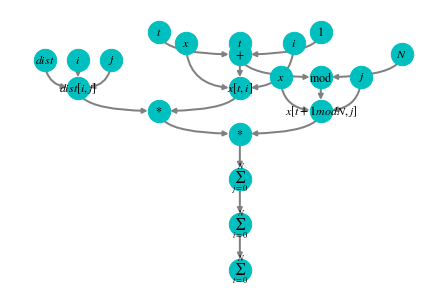

In [151]:
graph = Graph(problem_tsp.objective)
graph.make()
graph.draw(
    style="-",
    arrows="fancy",
    connectionstyle="angle3",
    width=2,
    node_color="c",
    node_size=500,
    edge_color="gray",
    font_size=12,
)

$$

In [88]:
import numpy as np

np.linspace(-10, 10, 4)

array([-10.        ,  -3.33333333,   3.33333333,  10.        ])

In [155]:
graph._data.edges

OutEdgeView([($\sum_{i=0}^{N}$, $\sum_{t=0}^{N}$), ($\sum_{j=0}^{N}$, $\sum_{i=0}^{N}$), ($*$, $\sum_{j=0}^{N}$), ($*$, $*$), ($x[t+1 mod N,j]$, $*$), ($dist[i,j]$, $*$), ($x[t,i]$, $*$), ($dist$, $dist[i,j]$), ($i$, $dist[i,j]$), ($j$, $dist[i,j]$), ($x$, $x[t,i]$), ($t$, $x[t,i]$), ($i$, $x[t,i]$), ($x$, $x[t+1 mod N,j]$), ($\mathrm{mod}$, $x[t+1 mod N,j]$), ($j$, $x[t+1 mod N,j]$), ($+$, $\mathrm{mod}$), ($N$, $\mathrm{mod}$), ($t$, $+$), ($1$, $+$)])

In [ ]:
def make_graph(graph: nx.DiGraph, node: Node):
    if isinstance(node.expression, jm.Number):
        graph.add_node(node)
    elif isinstance(node.expression, jm.Variable):
        graph.add_node(node)
    elif isinstance(node.expression, jm.UnaryOperator):
        pass
    elif isinstance(node.expression, jm.BinaryOperator):
        left, right = node.expression.left, node.expression.right
        lnode, rnode  = Node(left), Node(right)
    
        edges = [(lnode, node), (rnode, node)]
        graph.add_edges_from(edges)
        
        make_graph(graph, lnode)
        make_graph(graph, rnode)
    elif isinstance(node.expression, jm.expression.sum.ReductionOperator):
        pass
    elif isinstance(node.expression, jm.expression.condition.ConditionOperator):
        pass

In [5]:
from __future__ import annotations

import jijmodeling as jm
import networkx as nx
import numpy as np
import matplotlib

from typing import Tuple, List, Optional, Any



class Graph:
    space=1

    def __init__(self, expression: jm.Expression):
        self.expression = expression
        self._data = nx.DiGraph()

    @property
    def nodes(self):
        return self._data.nodes

    @property
    def edges(self):
        return self._data.edges

    def make(self, node: Optional[Node] = None, depth=0):
        if node is None:
            node = Node(self.expression)
            self._add_node(node, depth=depth)

        depth += 1
        if isinstance(node.expression, jm.Number):
            # self._data.add_node(node)
            pass
        elif isinstance(node.expression, jm.Variable):
            # self._data.add_node(node)
            pass
        elif isinstance(node.expression, jm.Subscripts):
            var = Node(node.expression.variable)
            subs = [Node(sub) for sub in node.expression.subscripts]
            self._add_nodes([var] + subs, depth=depth)

            edges = [(var, node)] + [(sub, node) for sub in subs]
            self._data.add_edges_from(edges)

            self.make(var, depth)
            for sub in subs:
                self.nodes[sub]["depth"] = depth
                self.make(sub, depth)
        elif isinstance(node.expression, jm.UnaryOperator):
            operand = Node(node.expression.operand)
            self._add_node(node, depth=depth)
            self._data.add_edge(operand, node)

            self.make(operand, depth)
        elif isinstance(node.expression, jm.BinaryOperator):
            left = Node(node.expression.left)
            right = Node(node.expression.right)
            self._add_nodes([left, right], depth=depth)

            edges = [(left, node), (right, node)]
            self._data.add_edges_from(edges)

            self.make(left, depth)
            self.make(right, depth)
        elif isinstance(node.expression, jm.expression.sum.ReductionOperator):
            operand = Node(node.expression.operand)
            self._add_node(operand, depth=depth)

            self._data.add_edge(operand, node)
            self.make(operand, depth)
        elif isinstance(node.expression, jm.expression.condition.ConditionOperator):
            pass

    def draw(self, **kwargs):
        matplotlib.rcParams["font.family"] = "Times New Roman"
        matplotlib.rcParams['mathtext.fontset'] = 'stix'
        node_map = {}
        for node in self.nodes:
            depth = self.nodes[node]["depth"]
            node_map[depth] = node_map.get(depth, []) + [node]

        pos = {}
        org = (0, 0)
        for depth, nodes in node_map.items():
            x = np.linspace(-len(nodes) - 1, len(nodes) - 1, len(nodes))
            for node, xi in zip(nodes, x):
                pos[node] = (org[0] + xi, org[1] +  depth)
        nx.draw(self._data, pos=pos, with_labels=True, **kwargs)

    def _add_node(self, node: Node, **attr: Any):
        self._data.add_node(node, **attr)

    def _add_nodes(self, nodes: List[Node], **attrs: Any):
        self._data.add_nodes_from([(node, attrs) for node in nodes])




class Node:
    def __init__(self, expression: jm.Expression, label: Optional[str]=None):
        self.expression = expression

    def __str__(self) -> str:
        if isinstance(self.expression, jm.Number):
            return f"${self.expression}$"
        elif isinstance(self.expression, jm.Variable):
            return f"${self.expression}$"
        elif isinstance(self.expression, jm.Subscripts):
            return f"${self.expression}$"
        elif isinstance(self.expression, jm.UnaryOperator):
            return  self.expression.__class__.__name__
        elif isinstance(self.expression, jm.BinaryOperator):
            if isinstance(self.expression, jm.expression.expression.Mod):
                return "$\mathrm{mod}$"
            else:
                return f"${self.expression._mark}$"
        elif isinstance(self.expression, jm.expression.sum.ReductionOperator):
            sum_index = ""
            if isinstance(self.expression.sum_index.parent, jm.expression.variables.variable.Range):
                sum_index += "{" + "{}={}".format(
                    self.expression.sum_index, self.expression.sum_index.parent.start
                )
                if not isinstance(self.expression.condition, jm.expression.condition.NoneCondition):
                    sum_index += f"({self.expression.condition})"
                sum_index += "}"
                sum_index += "^{" + str(self.expression.sum_index.parent.last) + "}"
            else:
                sum_index += "{" + f"{self.expression.sum_index} in {self.expression.sum_index.parent}"
                if self.expression.condition is not None:
                    sum_index += f"{self.expression.condition}"
                sum_index = sum_index + "}"

            if isinstance(self.expression, jm.expression.sum.SumOperator):
                op = "\sum"
            elif isinstance(self.expression, jm.expression.prod.ProdOperator):
                op = "\prod"
            else:
                op = ""
            return f"${op}_{sum_index}$"
        elif isinstance(self.expression, jm.expression.condition.ConditionOperator):
            return ""
        else:
            return ""

    

In [ ]:
import sys

sys.path.append("../")

import jijbench as jb

problem_tsp = jb.get_problem("TSP")
problem_tsp

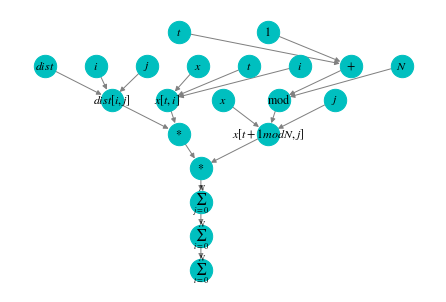

In [8]:
graph = Graph(problem_tsp.objective)
graph.make()
graph.draw(
    style="-",
    arrows="fancy",
    width=1,
    node_color="c",
    node_size=500,
    edge_color="gray",
    font_size=12,
)

In [41]:
nodes = list(graph._data.nodes)
node = list(graph._data.nodes)[0]
index = [nodes.index(node) for node in nodes]
index

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [21]:
graph.nodes

NodeView(($\sum_{t=0}^{N}$, $\sum_{i=0}^{N}$, $\sum_{j=0}^{N}$, $*$, $*$, $x[t+1 mod N,j]$, $dist[i,j]$, $x[t,i]$, $dist$, $i$, $j$, $x$, $t$, $i$, $x$, $\mathrm{mod}$, $j$, $+$, $N$, $t$, $1$))

In [45]:
import numpy as np

node_map = {}
for node in graph.nodes:
    depth = graph.nodes[node]["depth"]
    node_map[depth] = node_map.get(depth, []) + [node]

pos = {}
org = (0, 0)
for depth, nodes in node_map.items():
    x = np.linspace(-len(nodes) - 1, len(nodes) - 1, len(nodes))
    for node, xi in zip(nodes, x):
        pos[node] = (org[0] + xi, org[1] + depth)

pos

{$\sum_{t=0}^{N}$: (-2.0, 0),
 $\sum_{i=0}^{N}$: (-2.0, 1),
 $\sum_{j=0}^{N}$: (-2.0, 2),
 $*$: (-2.0, 3),
 $*$: (-3.0, 4),
 $x[t+1 mod N,j]$: (1.0, 4),
 $dist[i,j]$: (-6.0, 5),
 $x[t,i]$: (-3.5, 5),
 $x$: (-1.0, 5),
 $\mathrm{mod}$: (1.5, 5),
 $j$: (4.0, 5),
 $dist$: (-9.0, 6),
 $i$: (-6.714285714285714, 6),
 $j$: (-4.428571428571429, 6),
 $x$: (-2.1428571428571432, 6),
 $t$: (0.14285714285714235, 6),
 $i$: (2.428571428571427, 6),
 $+$: (4.7142857142857135, 6),
 $N$: (7.0, 6),
 $t$: (-3.0, 7),
 $1$: (1.0, 7)}

In [43]:
import numpy as np

np.linspace(-0, 0, 1)

array([0.])

In [25]:
from networkx.classes.reportviews import NodeView

nx.classes.reportviews.NodeView

networkx.classes.reportviews.NodeView

NameError: name 'nodes' is not defined

In [52]:
graph.nodes[node]["layer"] = 1
graph.nodes[node]

{'layer': 1}

In [7]:
graph = nx.DiGraph()
graph.add_node(1)
graph.add_node(2)
graph.add_edge(1, 2)
graph.nodes

NodeView((1, 2))

In [8]:
graph.edges

OutEdgeView([(1, 2)])

In [ ]:
        # if isinstance(self.left, Placeholder):
        #     if self.left.shape != left.shape:
        #         raise DataError(f"Shape of left value does not match shape of placeholder '{self.left}'.")
# 
        # if isinstance(self.right, Placeholder):
        #     if self.right.shape != right.shape:
        #         raise DataError(f"Shape of right value does not match shape of placeholder '{self.left}'.")

In [86]:
from __future__ import annotations

from abc import ABCMeta, abstractmethod
from typeguard import typechecked


import typing as tp
import numpy as np
import networkx as nx
import jijmodeling as jm

from jijmodeling.expression import expression
from jijmodeling.expression.variables import Element
from jijmodeling.expression.condition import Condition
from jijmodeling.expression.sum import INDEXWITHCOND
from jijmodeling.exceptions import DataError
from numpy._typing import NDArray


ARRAY_LIKE = tp.Union[jm.NumberValue ,tp.Iterable[jm.NumberValue]]


class Node(metaclass=ABCMeta):
    @abstractmethod
    def __init__(self) -> None:
        pass

    @abstractmethod
    def __str__(self) -> str:
        pass

    @property
    @abstractmethod
    def data(self) -> np.ndarray:
        pass

    @data.setter
    def data(self, data: np.ndarray) -> None:
        pass

    @property
    @abstractmethod
    def grad(self) -> np.ndarray:
        pass

    @grad.setter
    def grad(self, grad: np.ndarray) -> None:
        pass

    @property
    @abstractmethod
    def expression(self) -> jm.Expression:
        pass

    @property
    @abstractmethod
    def children(self) -> List[Node]:
        pass


class Variable(Node):
    def __init__(self, label: str, data: np.ndarray) -> None:
        if not isinstance(data, np.ndarray):
            raise TypeError("Type of 'data' must be np.ndarray.")
        self.label = label
        self._data = data
        self._grad = np.array([])
        self._expression = jm.Variable(label)
        self._children = []

    def __str__(self) -> str:
        return f"${self.expression}$"

    @property
    def data(self) -> np.ndarray:
        return self._data

    @data.setter
    def data(self, data: np.ndarray) -> None:
        if not isinstance(data, np.ndarray):
            raise TypeError("Type of 'data' must be np.ndarray.")
        self._data = data

    @property
    def grad(self) -> np.ndarray:
        return self._grad

    @grad.setter
    def grad(self, grad: np.ndarray) -> None:
        if not isinstance(grad, np.ndarray):
            raise TypeError("Type of 'data' must be np.ndarray.")
        self._grad = grad

    @property
    def expression(self) -> jm.Variable:
        return self._expression

    @property
    def children(self) -> List[Node]:
        return self._children


class Placeholder(Node):
    def __init__(self, label):
        self.label = label

        self._data = np.array([])
        self._grad = np.array([])
        self._expression = jm.Placeholder(label)
        self._children = []

    def __str__(self) -> str:
        return f"${self.expression}$"

    @property
    def data(self) -> np.ndarray:
        return self._data

    @property
    def grad(self) -> np.ndarray:
        return self._grad

    @property
    def expression(self) -> jm.Variable:
        return self._expression

    @property
    def children(self) -> List[Node]:
        return self._children

class Binary(Placeholder):
    def __init__(
            self,
            label: str
        ) -> None:
        super().__init__(label)
        self._expression = jm.Binary(label)

    def __repr__(self) -> str:
        return f"${self.expression}$"

class Integer(Placeholder):
    def __init__(
        self,
        label: str,
        lower: tp.Union[jm.Expression, int, float],
        upper: tp.Union[jm.Expression, int, float],
        ) -> None:
        super().__init__(label)
        self._expression = jm.Integer(label, lower, upper)


class Continuous(Placeholder):
    def __init__(
            self,
            label: str,
        ) -> None:
        super().__init__(label)

    def __repr__(self) -> str:
        return f"${self.expression}$"


class Operator(Node):
    def __init__(self) -> None:
        self._children = None
        self._data = np.array([])
        self._grad = np.array([])

    def __str__(self) -> str:
        return f"${self.expression}$"

    @property
    def data(self) -> np.ndarray:
        return self._data

    @data.setter
    def data(self, data: np.ndarray) -> None:
        if not isinstance(data, np.ndarray):
            raise DataError("Type of 'data' must be np.ndarray.")
        self._data = data

    @property
    def grad(self) -> np.ndarray:
        return self._grad

    @grad.setter
    def grad(self, grad: np.ndarray) -> None:
        self._grad = grad

    @property
    def expression(self) -> jm.Expression:
        raise NotImplementedError

    @expression.setter
    def expression(self, expression) -> None:
        self._expression = expression

    @property
    def children(self) -> tp.Optional[List[Node]]:
        return self._children

    @children.setter
    def children(self, nodes: List[Node]) -> None:
        self._children = nodes

    def forward(self, *nodes: Node) -> Operator:
        self.children = list(nodes)
        self.data = self._forward(*nodes)
        return self

    def _forward(self, *children: Node) -> np.ndarray:
        raise NotImplementedError("Operation does not implemented.")

    def backward(self) -> tp.Tuple[Node, ...]:
        if self.children is None:
            raise ValueError("Child node for operation is None.")
        else:
            for node in self.children:
                pass
            return self.children

    def _backward(self, *children: Node) -> tp.Tuple[np.ndarray, ...]:
        raise NotImplementedError("Operation does not implemented.")


class Add(Operator):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, left: Node, right: Node) -> Operator:
        self._expression = expression.Add(left.expression, right.expression)
        return super().forward(left, right)

    def _forward(self, *children: Node) -> np.ndarray:
        left, right = children

        if len(left.data) and len(right.data):
            data = left.data + right.data
        else:
            data = np.array([])
        return data

    def backward(self) -> tp.Tuple[Node]:
        self.grad = self._backward()
        return super().backward()

    def _backward(self, *children: Node) -> np.ndarray:
        return self.data

    def __repr__(self):
        return f"$+$"

    @property
    def expression(self) -> jm.Expression:
        return self._expression

class Sub(Node):
    pass

class Mul(Node):
    pass

class Div(Node):
    pass

class Pow(Node):
    pass

class Mod(Node):
    pass

class MatMul(Operator):
    def __init__(self, left: Node, right: Node) -> None:
        super().__init__(left, right)


class Sum(Node):
    def __init__(
            self,
            indices: tp.Union[INDEXWITHCOND, tp.List[INDEXWITHCOND]],
            term: jm.Expression,
        ) -> None:
        self._expression = jm.Sum(indices,term)







class Test1(Node):
    def __init__(self):
        self.x = Binary("x")

    def __call__(self, x, y):
        return self.forward(x, y)

    def objective(self, a):
        v = Add(self.x, a)
        return e

In [8]:
a = {}
a.update({0:1, "a": "b"})
print(a)
a.clear()
a

{0: 1, 'a': 'b'}


{}

In [10]:
import datetime as dt

type(dt.datetime.now())

datetime.datetime

In [2]:
def draw(node: Node):
    graph = nx.DiGraph()
    edges = [(child, node) for child in node.children]
    graph.add_edges_from(edges)
    edge_labels =  {edge: edge[0].data for edge in edges}
    pos = {node: (0, 0)}
    pos |= {child: (pos[node][0] + i, pos[node][1] + 1) for i, child in enumerate(node.children)}
    nx.draw_networkx(graph, pos, with_labels=True)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

In [87]:
a = Variable("a", np.array([1]))
b = Variable("b", np.array([2]))
obj1 = Add()
y1 = obj1.forward(a, b)

a = Variable("a", np.array([1]))
x = Continuous("x")
obj2 = Add()
y2 = obj2.forward(a, b)

obj3 = Add()
obj3.forward(y1, y2)
print(obj3.data)

# draw(obj3)

[6]


In [88]:
obj1.backward()

(array([3]), array([3]))

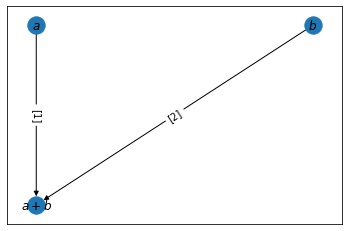

In [89]:
draw(obj1)

In [84]:
obj1.data

array([3])

In [49]:
x = np.array(["a"])
x.all()

UFuncTypeError: ufunc 'logical_and' did not contain a loop with signature matching types (None, <class 'numpy.dtype[str_]'>) -> None

In [66]:
empty = np.array([])
empty

[]

In [27]:
jm.Binary("x")

x

In [9]:
a = jm.Variable("a")
b = jm.Variable("b")

p = jm.Placeholder("b")

expression.Add(a, b)

a+b

In [14]:
a = Variable("a", np.array([1]))
a.expression.is_operatable()

False

In [8]:
import numpy as np
import chainer
from chainer import variable
from chainer import functions as F


x = variable.Variable(np.array(1.))
y = variable.Variable(np.array(2.))

obj = x + y
obj.backward()
print(x.grad)
print(y.grad)
print(obj.grad)
print(obj)
print(obj.requires_grad)


1.0
1.0
None
variable(3.)
True


TypeError: unsupported operand type(s) for +: 'int' and 'list'

In [15]:
raise DataError("Attribute 'data' is None. Execute forward computation of Add and get data.")

DataError: Attribute 'data' is None. Execute forward computation of Add and get data.

In [27]:
a = Variable("a", np.array([1]))
b = Variable("b", np.array([2]))
obj1 = Add()
y1 = obj1.forward(a, b)

a = Variable("a", np.array([1]))
x = Continuous("x")
obj2 = Add()
y2 = obj2.forward(a, x)

obj3 = Add()
obj3.forward(y1, y2)
print(obj3.data)

draw(obj3)

ModelingError: a is not operatable. If a should be operatable, please check the subscripts and dim of a.

In [15]:
isinstance(np.array(1.0), np.ndarray)

True

10


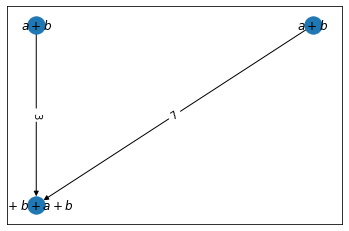

In [14]:
a = Placeholder("a")
b = Placeholder("b")
obj1 = Add(a, b)
obj1.forward(np.array(1), np.array(2))

a = Placeholder("a")
b = Placeholder("b")
obj2 = Add(a, b)
obj2.forward(np.array(3), np.array(4))

obj3 = Add(obj1, obj2)
obj3.forward()
print(obj3.data)

draw(obj3)

a+x


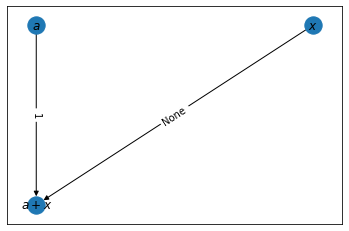

In [47]:
a = Placeholder("a")
x = Continuous("x")
obj1 = Add(a, x)
obj1.forward(np.array(1), np.array(2))
draw(obj1)

In [ ]:
a = Placeholder("a")
x = Continuous("x")
obj1 = Add(a, x)
obj1.forward(np.array(1), np.array(2))

In [40]:
x.expression.is_operatable()

False

In [28]:
a = jm.Placeholder("a")
x = jm.Variable("x")
y = jm.Variable("y")

expression.Add(x, a)

x+a

In [4]:
class A:
    @property
    def data(self):
        return 1
    
a = A()
a.data

1

In [64]:
np.zeros((100, 100, 100)).all() is None
np.array([]).all() is None

True

In [18]:
np.array([]) is np.array([])

False

In [90]:
import jijmodeling_engine as jme
import pprint

def get_qubo(problem, instance_data):
    engine = jme.JijModelingEngine(
        problem, {"a": 1.0}, {}
    )
    engine.compile()
    engine.set_default_parameters({})
    qubo, bias = engine.get_qubo()
    pprint.pprint(qubo)
    print(bias)

problem = jm.Problem("sample")

a = jm.Placeholder("a")
x = jm.Binary("x")
problem += a * x * x

get_qubo(problem, {"a": 2})

{(0, 0): 1.0}
0.0


In [91]:
problem

In [88]:
problem = jm.Problem("sample")

a = jm.Placeholder("a")
i = jm.Element("i", 2)
j = jm.Element("j", 2)
x = jm.Binary("x", (2,))
problem += a * jm.Sum([i, j], x[i] * x[j])

get_qubo(problem, {"a": 1.0})

{(0, 0): 0.5, (0, 1): 1.0, (1, 1): 0.5}
0.0


In [89]:
problem

In [ ]:
problem = jm.Problem("sample")

a = jm.Placeholder("a")
x = jm.Binary("x", (2, 2))
problem += a * x[:]

engine = jme.JijModelingEngine(
    problem, {"a": 1.0}, {}
)
engine.compile()
engine.set_default_parameters({})
qubo, bias = engine.get_qubo()
pprint.pprint(qubo)
print(bias)

In [6]:
x = jm.Binary("x")
a = jm.Placeholder("a")

obj = x + a
type(obj)

jijmodeling.expression.expression.Add

In [23]:
problem = Test1()
problem(1, 2)

3

In [4]:
class A(jm.Binary):
    def __init__(self, label: str, shape=..., uuid: Optional[str] = None):
        super().__init__(label, shape, uuid)
        
        
class B(jm.expression.sum.SumOperator):
    def __init__(self, sum_index: _variable.Element, operand: _expression.Expression, condition: tp.Optional[_conditions.Condition] = None, uuid: tp.Optional[str] = None) -> None:
        super().__init__(sum_index, operand, condition, uuid)
        
class C(expression.Add):
    def __init__(self, left: Expression, right: Expression, uuid: Optional[str] = None):
        super().__init__(left, right, uuid)
        
        
class D(jm.Placeholder):
    def __init__(self, label: str, dim: tp.Optional[int] = None, shape=None, uuid: tp.Optional[str] = None):
        super().__init__(label, dim, shape, uuid)
        
jm.Placeholder()

TypeError: __init__() missing 2 required positional arguments: 'left' and 'right'

3

True

In [ ]:
import sys

sys.path.append("../")

import jijbench as jb

problem_tsp = jb.get_problem("TSP")
problem_tsp

In [21]:
import numpy as np

# value = np.random.randint(0, 10, (3, 3))
value = 1
a = Placeholder(value, "a")


In [4]:
import jijmodeling as jm
jm.NumberValue

typing.Union[int, float]

In [12]:
import typing as tp
import numpy as np

x = np.array(range(0, 10, 2))
x

isinstance(1, tp.Iterable)

False

In [11]:
x: tp.Iterable[int] =  [1, 2, 3]

3
<class '__main__.Placeholder'>


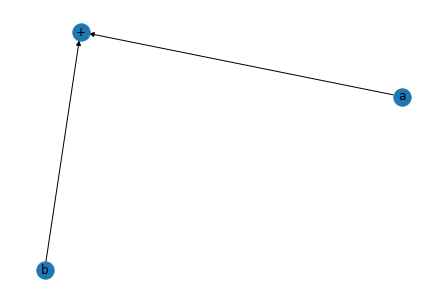

In [22]:
a = Placeholder(1, "a")
b = Placeholder(2, "b")
# p1 = Placeholder("a", (3, 3))
# p2 = Placeholder("b", (3, 3))
obj = Add()
res = obj(a, b)
print(res.data)
print(type(res))
nx.draw(res.graph, with_labels=True)

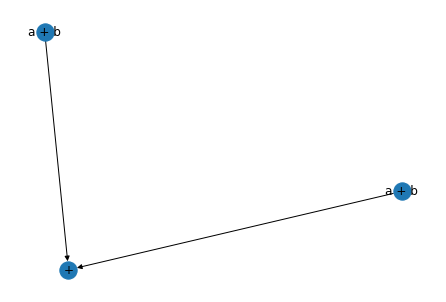

In [24]:
new_obj = Add()
new_res = new_obj(obj(a, b), obj(a, b))
nx.draw(new_res.graph, with_labels=True)

In [162]:
a1 = Placeholder(1, "a1")
b1 = Placeholder(2, "b1")
obj1 = Add()
a2 = Placeholder(1, "a2")
b2 = Placeholder(2, "b2")
obj2 = Add()
res1 = obj1(a1, b1)
res2 = obj2(a2, b2)
new_obj = Add()
res3 = new_obj(res1, res2)

# graph1 = nx.compose(res1.graph, graph)
# graph2 = nx.compose(res2.graph, graph)
# graph3 = nx.compose(graph1, graph2)

# graph = nx.Graph()
# edges = [edge for edge in res1.graph.edges]
# graph.add_weighted_edges_from(edges)
# graph.add_edges_from(edges)
# nx.draw(graph, with_labels=True)
# graph.edges[list(graph.edges)[0]]

# print(graph1.nodes)
# nx.draw(res3.graph, with_labels=True)

[]
[]
[]
[]
[(a1, $+$), ($+$, a1 + b1), (b1, $+$)]
[(a2, $+$), ($+$, a2 + b2), (b2, $+$)]


In [163]:
for edge in res3.graph.edges:
    print(res3.graph.edges[edge])

{'weight': array(1)}
{}
{'weight': array(3)}
{'weight': array(2)}
{'weight': array(1)}
{}
{'weight': array(3)}
{'weight': array(2)}
{}


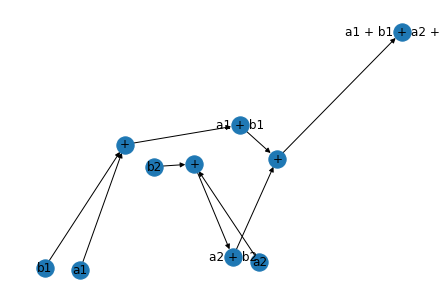

In [164]:
nx.draw(res3.graph, with_labels=True)

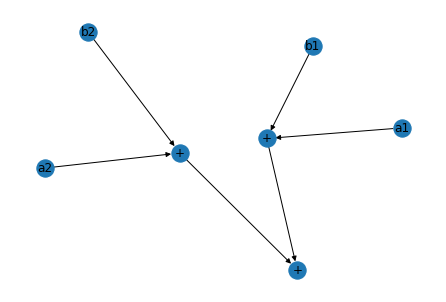

In [123]:
new_obj = Add()
# new_obj(res1, res2)
graph = nx.DiGraph()
# graph.add_edges_from([(1, 3), (2, 3)])
# print(graph.pred[3])
# nx.draw(graph, with_labels=True)
graph.add_edges_from(res1.graph.edges)
graph.add_edge(obj1, new_obj)
graph.add_edges_from(res2.graph.edges)
graph.add_edge(obj2, new_obj)
nx.draw(graph, with_labels=True)

TypeError: add_edge() missing 1 required positional argument: 'v_of_edge'

In [106]:
graph.nodes

NodeView((a1, <__main__.Add object at 0x7f280f9bcd60>, b1, <__main__.Add object at 0x7f280f7c8370>, a2, <__main__.Add object at 0x7f280f6f5220>, b2))

In [98]:
res1.graph.edges

OutEdgeView([(a1, <__main__.Add object at 0x7f2810c25970>), (b1, <__main__.Add object at 0x7f2810c25970>)])

In [99]:
res2.graph.edges

OutEdgeView([(a2, <__main__.Add object at 0x7f2810c25970>), (b2, <__main__.Add object at 0x7f2810c25970>)])

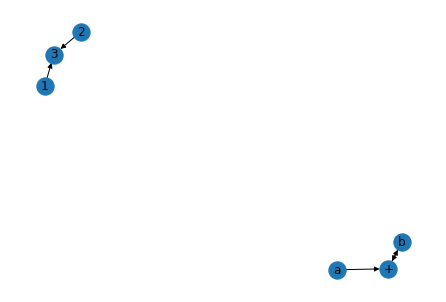

In [12]:
from typeguard import typechecked

@typechecked
def func(x: int):
    return x

func(1.0)

TypeError: type of argument "x" must be int; got float instead

In [14]:
class A:
    def __init__(self):
        self.x = 1
        
a = A()
a.y

AttributeError: 'A' object has no attribute 'y'

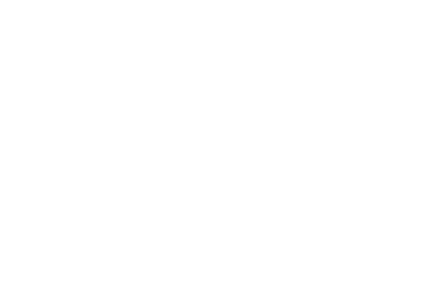

In [91]:
nx.draw(p1.graph, with_labels=True)

In [49]:
x = jm.Placeholder("x")

0

In [34]:
any([False, False])

False

In [35]:
from abc import ABCMeta, abstractmethod

class A(metaclass=ABCMeta):
    @abstractmethod
    def func():
        pass
    
class AA(A):
    pass

aa = AA()


TypeError: Can't instantiate abstract class AA with abstract method func

In [31]:
np.array([]) + 1

TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'

{(<__main__.Placeholder at 0x7f435599aeb0>,
  <__main__.Add at 0x7f4355a2fc40>): Text(-0.5, -0.5, '[[4 8 7 ... 9 5 3]\n [3 7 9 ... 9 9 8]\n [5 1 8 ... 5 8 9]\n ...\n [9 9 8 ... 8 3 2]\n [7 0 4 ... 2 5 6]\n [0 5 0 ... 5 4 0]]'),
 (<__main__.Placeholder at 0x7f4355a28e50>,
  <__main__.Add at 0x7f4355a2fc40>): Text(0.5, -0.5, '[[8 3 2 ... 3 7 3]\n [9 4 5 ... 2 0 5]\n [8 3 9 ... 5 9 1]\n ...\n [0 6 0 ... 5 8 5]\n [3 7 8 ... 0 9 3]\n [5 1 4 ... 4 1 3]]')}

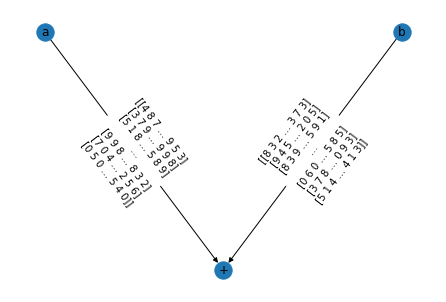

In [88]:
edge_labels = {edge[0:2]: edge[2]["weight"] for edge in obj.graph.edges(data=True)}
pos = {obj.left: (-1, 0), obj.right: (1, 0), obj: (0, -1)}
nx.draw(obj.graph, pos, with_labels=True)
nx.draw_networkx_edge_labels(obj.graph, pos, edge_labels=edge_labels)

In [30]:
print(op)

x


In [ ]:
jm.BinaryOperator

In [72]:
import numpy as np
from chainer.variable import Variable, VariableNode
from chainer.function_node import FunctionNode
from chainer.functions.math.basic_math import Add

a = Variable(np.array(10.0))
x = Variable(np.array(2.0))
y = Variable(np.array(1.0))
# print(a.grad)
# print(x.grad)
# print(y.grad)
# print()

res = a * x + y
res.backward()

print("=====")
# print(a.grad)
# print(x.grad)
# print(y.grad)
# print(res.grad)
#print()

# print(res.node.get_variable_or_none())
print(res.node.rank)
print(res.node.creator.inputs)
print("*****")
print(res.node.creator.inputs[0].data, res.node.creator.inputs[1].data)
print(res.node.creator.inputs[0].rank, res.node.creator.inputs[1].rank)
print("+++++")
print(res.node.creator.inputs[0].creator.inputs[0].data, res.node.creator.inputs[0].creator.inputs[1].data)
print(res.node.creator.inputs[0].creator.inputs[0].rank, res.node.creator.inputs[0].creator.inputs[1].rank)
print(":::::")
print(res.node.creator.inputs[1].data)
print(res.node.creator.inputs[0].grad)
print(res.node.creator)

(<chainer.variable.VariableNode object at 0x7f364b46aac0>, <chainer.variable.VariableNode object at 0x7f364b32b490>)
;;;;;
(<chainer.variable.VariableNode object at 0x7f364b32b610>, <chainer.variable.VariableNode object at 0x7f364b32b370>)
;;;;;
10.0
faf
None
faf
2.0
faf
=====
2
(<chainer.variable.VariableNode object at 0x7f364b46aac0>, <chainer.variable.VariableNode object at 0x7f364b32b490>)
*****
None None
1 0
+++++
10.0 2.0
0 0
:::::
None
None


In [ ]:
from __future__ import annotations

from abc import ABCMeta, abstractmethod
from typeguard import typechecked


import typing as tp
import numpy as np
import networkx as nx
import jijmodeling as jm

from jijmodeling.expression import expression
from jijmodeling.expression.variables import Element
from jijmodeling.expression.condition import Condition
from jijmodeling.expression.sum import INDEXWITHCOND
from jijmodeling.exceptions import DataError
from numpy._typing import NDArray


ARRAY_LIKE = tp.Union[jm.NumberValue ,tp.Iterable[jm.NumberValue]]



class Node(metaclass=ABCMeta):
    @abstractmethod
    def __init__(self) -> None:
        pass

    @abstractmethod
    def __str__(self) -> str:
        pass

    @property
    @abstractmethod
    def expression(self) -> jm.Expression:
        pass

    @property
    @abstractmethod
    def children(self) -> List[Node]:
        pass

    @property
    @abstractmethod
    def data(self) -> np.ndarray:
        pass

    @property
    @abstractmethod
    def grad(self) -> np.ndarray:
        pass


class Operand(Node):
    def __init__(self, label: str, shape: tp.Optional[tp.Tuple[int,...]]) -> None:
        self.label = label
        self.shape = shape if shape else ()

        self._expression = jm.Variable(label, shape)
        self._children = []
        self._data = np.array([])
        self._grad = np.array([])

    def __str__(self) -> str:
        return f"${self.expression}$"

    @property
    def expression(self) -> jm.Variable:
        return self._expression

    @property
    def children(self) -> List[Node]:
        return self._children

    @property
    def data(self) -> np.ndarray:
        return self._data

    @property
    def grad(self) -> np.ndarray:
        return self._grad


class Operator(Node):
    def __init__(self, *children: Node) -> None:
        self._children = list(children)
        self._data = np.array([])
        self._grad = np.array([])

    def __str__(self) -> str:
        return f"${self.expression}$"

    @property
    def expression(self) -> jm.Expression:
        raise NotImplementedError

    @property
    def children(self) -> List[Node]:
        return self._children

    @property
    def data(self) -> np.ndarray:
        return self._data

    @property
    def grad(self) -> np.ndarray:
        return self._grad

    @data.setter
    def data(self, data: np.ndarray) -> None:
        self._data = data

    def forward(self, *data: np.ndarray | None) -> Operator:
        for node, x in zip(self.children, data):
            if isinstance(node, Placeholder) and x is not None:
                if not isinstance(x, np.ndarray):
                    raise TypeError(f"Type of input data must be np.ndarray, not {type(x)}.")
                if node.shape != x.shape:
                    raise DataError(f"Shape of placeholder '{node}' does not match shape of actual data.")
                node.data = x
        self.data = self._forward(*self.children)
        return self

    def _forward(self, *children: Node) -> np.ndarray:
        raise NotImplementedError("Operation does not implemented.")

    def backward(self, *grad: np.ndarray):
        self._backward()

    def _backward(self, *children: Node) -> np.ndarray:
        raise NotImplementedError("Operation does not implemented.")


class Add(Operator):
    def __init__(self, left: Node, right: Node) -> None:
        super().__init__(left, right)
        print(expression.Add(left.expression, right.expression))
        self._expression = expression.Add(left.expression, right.expression)

    def forward(self, left: tp.Optional[np.ndarray] = None, right: tp.Optional[np.ndarray] = None) -> Operator:
        return super().forward(left, right)

    def backward(self):
        return

    def _forward(self, *children: Node) -> np.ndarray:
        left, right = children

        if not (left.data.all() is None or right.data.all() is None):
            data = left.data + right.data
        else:
            data = np.array([])
        return data

    def __repr__(self):
        return f"$+$"

    @property
    def expression(self) -> jm.Expression:
        return self._expression

class Sub(Node):
    pass

class Mul(Node):
    pass

class Div(Node):
    pass

class Pow(Node):
    pass

class Mod(Node):
    pass

class MatMul(Operator):
    def __init__(self, left: Node, right: Node) -> None:
        super().__init__(left, right)


class Sum(Node):
    def __init__(
            self,
            indices: tp.Union[INDEXWITHCOND, tp.List[INDEXWITHCOND]],
            term: jm.Expression,
        ) -> None:
        self._expression = jm.Sum(indices,term)

class Placeholder(Operand):
    def __init__(
            self,
            label: str,
            shape: tp.Optional[tp.Tuple[int,...]] = None
        ) -> None:
        super().__init__(label, shape)
        self._expression = jm.Placeholder(label)

    def __repr__(self) -> str:
        return f"${self.expression}$"

    @property
    def data(self) -> np.ndarray:
        return self._data

    @data.setter
    def data(self, data: np.ndarray) -> None:
        self._data = data

class Variable(Node):
    pass

class Binary(Operand):
    def __init__(
            self,
            label: str,
            shape: tp.Optional[tuple[int, ...]] = None
        ) -> None:
        super().__init__(label, shape)
        self._expression = jm.Binary(label, shape if shape else ())

    def __repr__(self) -> str:
        return f"${self.expression}$"

    @property
    def expression(self) -> jm.Expression:
        return self._expression

class Integer(Node):
    pass

class Continuous(Operand):
    def __init__(
            self,
            label: str,
            shape: tp.Optional[tuple[int, ...]] = None
        ) -> None:
        super().__init__(label, shape)
        self.expression.is_operatable = lambda: True

    def __repr__(self) -> str:
        return f"${self.expression}$"



class Test1(Node):
    def __init__(self):
        self.x = Binary("x")

    def __call__(self, x, y):
        return self.forward(x, y)

    def objective(self, a):
        v = Add(self.x, a)
        return e

In [63]:
import torch

a = torch.tensor(10.0, requires_grad=True)
x = torch.tensor(2.0, requires_grad=True)
y = torch.tensor(1.0, requires_grad=True)
z = a * x + y

z.backward()
z.grad_fn.next_functions[1][0].next_functions

()